In [1]:
#!/usr/bin/env python3
"""
Trolley Problem Analysis - Prior Predictive Only
================================================
Using Our bayes_ordinal Package
================================================
"""

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Import our bayes_ordinal package
import sys
sys.path.append('..')
import bayes_ordinal as bo

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("TROLLEY PROBLEM ANALYSIS - PRIOR PREDICTIVE ONLY")
print("=" * 60)
print("Using Our bayes_ordinal Package")
print("=" * 60)

TROLLEY PROBLEM ANALYSIS - PRIOR PREDICTIVE ONLY
Using Our bayes_ordinal Package


In [2]:
print("1. Loading and Cleaning Data...")
print("=" * 50)

# Load the trolley dataset with correct separator
data = pd.read_csv("../Dataset/Trolley.csv", sep=';')
print(f" Raw dataset shape: {data.shape}")

# Clean the data
data = data.dropna()
print(f" Cleaned dataset shape: {data.shape}")

# Check response variable
print(f" Response range: {data['response'].min()} to {data['response'].max()}")
print(f" Number of categories: {data['response'].nunique()}")
print(f" Features: {['action', 'intention', 'contact']}")

# Display response distribution
print("\nResponse distribution:")
print(data['response'].value_counts().sort_index())

# Prepare features
feature_cols = ['action', 'intention', 'contact']
X = data[feature_cols].values
y = data['response'].values

# Convert to 0-based indexing for PyMC
y_zero_based = y - 1
print("\n2. Data Validation...")
print("=" * 50)

# Validate data using our package
validation_results = bo.validate_ordinal_data(y_zero_based, X)
print(" Data validation completed")

print("\n3. Data Exploration...")
print("=" * 50)

# Feature summary
print("Feature Summary:")
for i, col in enumerate(feature_cols):
    print(f"  {col}: mean={X[:, i].mean():.3f}, std={X[:, i].std():.3f}")

# Correlation matrix
corr_matrix = pd.DataFrame(X, columns=feature_cols).corr()
print(f"\nFeature Correlation Matrix:")
print(corr_matrix.round(3))

print(" Data exploration completed")

1. Loading and Cleaning Data...
 Raw dataset shape: (9930, 12)
 Cleaned dataset shape: (9930, 12)
 Response range: 1 to 7
 Number of categories: 7
 Features: ['action', 'intention', 'contact']

Response distribution:
response
1    1274
2     909
3    1071
4    2323
5    1462
6    1445
7    1446
Name: count, dtype: int64

2. Data Validation...
 Data validation completed

3. Data Exploration...
Feature Summary:
  action: mean=0.433, std=0.496
  intention: mean=0.467, std=0.499
  contact: mean=0.200, std=0.400

Feature Correlation Matrix:
           action  intention  contact
action      1.000     -0.144   -0.437
intention  -0.144      1.000    0.033
contact    -0.437      0.033    1.000
 Data exploration completed


In [3]:
print("\n4. Prior Specification...")
print("=" * 50)

# Define priors for the cumulative model
priors = {
    "beta": [0, 0.5],       # [mu, sigma] for beta
    "sigma": 1,           #  Normal(0, 1) for cutpoints
    "mu": np.array([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]),      # mu=0 for all cutpoints
    "constrained_uniform": False
}

print("Prior specifications (matching OC exactly):")
print(f"  beta: {priors['beta']} (coefficient mean=0, std=0.5 - like OC)")
print(f"  sigma: {priors['sigma']} (cutpoint prior std=1.0 - like OC)")
print(f"  mu: {priors['mu']} (cutpoint means=0 for all - like OC)")


4. Prior Specification...
Prior specifications (matching OC exactly):
  beta: [0, 0.5] (coefficient mean=0, std=0.5 - like OC)
  sigma: 1 (cutpoint prior std=1.0 - like OC)
  mu: [-2.5 -1.5 -0.5  0.5  1.5  2.5] (cutpoint means=0 for all - like OC)



5. Building Model (Using Our Package)...
Building logit model...
 Logit model built successfully

Model Structure:
Model Structure (PyMC Graphviz):


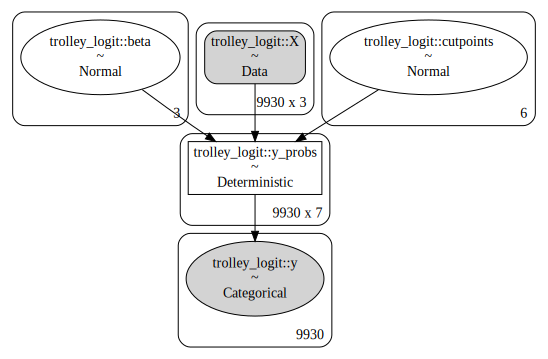

 Graphviz visualization displayed successfully!


In [4]:
print("\n5. Building Model (Using Our Package)...")
print("=" * 50)

print("Building logit model...")

# Build the logit model using our package
logit_model = bo.cumulative_model(
    y=y_zero_based,
    X=X,
    K=len(np.unique(y_zero_based)),  # Number of unique categories
    link="logit",
    priors=priors,
    model_name="trolley_logit",
    prior_type="fixed_sigma",
    feature_names=feature_cols
)

print(" Logit model built successfully")

# Display model structure
print("\nModel Structure:")
print("Model Structure (PyMC Graphviz):")

# Import pymc and create the model structure
import pymc as pm

# Create the graphviz visualization
model_graph = pm.model_to_graphviz(logit_model)

display(model_graph)
print(" Graphviz visualization displayed successfully!")

In [5]:
print("\n8. Model Fitting...")
print("=" * 50)

print("Fitting logit model...")

# Fit the model using our package - now with progress tracking!
idata_logit = bo.fit_ordinal_model(
    model=logit_model,
    chains=4,
    draws=1500,
    tune=1000,
    random_seed=42
    # progressbar=True and compute_convergence_checks=True are now default!
)

print(" Logit model fitting completed")
print(f" InferenceData shape: {idata_logit.posterior['trolley_logit::beta'].shape}")

Initializing NUTS using jitter+adapt_diag...



8. Model Fitting...
Fitting logit model...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [trolley_logit::beta, trolley_logit::cutpoints]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 106 seconds.
Sampling: [trolley_logit::y]


 Adding posterior predictive samples...


 Posterior predictive samples added
 Logit model fitting completed
 InferenceData shape: (4, 1500, 3)



5b. Building Probit Model...
Building probit model...
 Probit model built successfully
 Note: Prior scales automatically adjusted for probit (×0.625)

Probit Model Structure:
Model Structure (PyMC Graphviz):


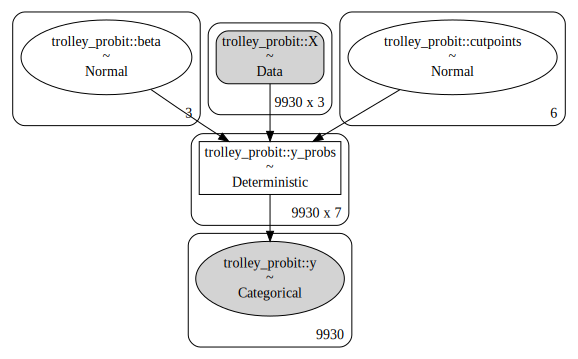

 Probit model Graphviz visualization displayed successfully!


In [6]:
print("\n5b. Building Probit Model...")
print("=" * 50)

print("Building probit model...")

# Build the probit model using our package
# Note: The same priors will be automatically adjusted for probit scale
probit_model = bo.cumulative_model(
    y=y_zero_based,
    X=X,
    K=len(np.unique(y_zero_based)),  # Number of unique categories
    link="probit",  # Changed to probit
    priors=priors,  # Same priors - will be automatically adjusted
    model_name="trolley_probit",
    prior_type="fixed_sigma",
    feature_names=feature_cols
)

print(" Probit model built successfully")
print(" Note: Prior scales automatically adjusted for probit (×0.625)")

# Display model structure
print("\nProbit Model Structure:")
print("Model Structure (PyMC Graphviz):")

# Create the graphviz visualization for probit model
model_graph_probit = pm.model_to_graphviz(probit_model)
display(model_graph_probit)
print(" Probit model Graphviz visualization displayed successfully!")

In [7]:
print("\n8b. Fitting Probit Model...")
print("=" * 50)

print("Fitting probit model...")

# Fit the probit model using our package
idata_probit = bo.fit_ordinal_model(
    model=probit_model,
    chains=4,
    draws=1500,
    tune=1000,
    random_seed=42
)

print(" Probit model fitting completed")
print(f" InferenceData shape: {idata_probit.posterior['trolley_probit::beta'].shape}")


8b. Fitting Probit Model...
Fitting probit model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [trolley_probit::beta, trolley_probit::cutpoints]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 625 seconds.
Sampling: [trolley_probit::y]


 Adding posterior predictive samples...


 Posterior predictive samples added
 Probit model fitting completed
 InferenceData shape: (4, 1500, 3)


In [8]:
# Cell: Model Comparison Setup
print(" Setting up model comparison...")

# Create dictionaries for easy access
models = {
    'Logit': logit_model,
    'Probit': probit_model
}

idatas = {
    'Logit': idata_logit,
    'Probit': idata_probit
}

print(f" Models ready for comparison: {list(models.keys())}")
print(f" InferenceData ready: {list(idatas.keys())}")

 Setting up model comparison...
 Models ready for comparison: ['Logit', 'Probit']
 InferenceData ready: ['Logit', 'Probit']


In [9]:
# Cell: Advanced Model Comparison with Full Results
print(" Advanced Model Comparison with Full Results...")

# Import the advanced comparison function
from bayes_ordinal.workflow.cross_validation import compare_models_stacking

# Run advanced comparison (this will compute everything)
advanced_results = compare_models_stacking(
    models=models,
    idatas=idatas,
    ic="loo",
    include_stacking=True,
    include_bma=True
)

print(" Advanced comparison completed!")

 Advanced Model Comparison with Full Results...
 Log likelihood found for Logit
  Location: root level
 LOO computed successfully: -18545.17 ± 37.83
 Log likelihood found for Probit
  Location: root level
 LOO computed successfully: -18542.23 ± 38.10
 Advanced model comparison completed using ArviZ stacking
 Stacking weights computed successfully
 Bayesian Model Averaging weights computed
 Advanced comparison completed!


In [10]:
# Cell: Display Comprehensive Results
print(" Displaying Comprehensive Results...")

# Import the display function
from bayes_ordinal.workflow.cross_validation import display_comparison_results

# Display all results in a readable format
display_comparison_results(advanced_results)

print(" Results displayed!")

 Displaying Comprehensive Results...

COMPREHENSIVE MODEL COMPARISON RESULTS

 BASIC COMPARISON:
        rank   elpd_loo  p_loo  elpd_diff  weight      se   dse  warning  \
Probit     0  37084.464  9.063       0.00   0.713  76.198  0.00    False   
Logit      1  37090.333  9.126       5.87   0.287  75.652  7.45    False   

           scale  n_bad_k  
Probit  deviance        0  
Logit   deviance        0  

 BEST MODEL: Probit

 STACKING WEIGHTS:
  Probit: 0.713
  Logit: 0.287

 BAYESIAN MODEL AVERAGING WEIGHTS:
  Logit: 0.500
  Probit: 0.500

 CONVERGENCE DIAGNOSTICS:
  Logit:  CONVERGED
    R-hat max: 1.003
    ESS min: 2759
  Probit:  CONVERGED
    R-hat max: 1.002
    ESS min: 2860

 INFLUENCE DIAGNOSTICS:
  Logit:
    Influential obs (k > 0.7): 0
    Max k: 0.021
    Mean k: -0.063
  Probit:
    Influential obs (k > 0.7): 0
    Max k: 0.032
    Mean k: -0.062

 MODEL COMPLEXITY:
  Logit: 2 parameters
  Probit: 2 parameters

 RECOMMENDATIONS:
  • Consider using stacking weights for

 Creating Rich Model Comparison Plots...
 Log likelihood found for Logit
  Location: root level
 LOO computed successfully: -18545.17 ± 37.83
 Log likelihood found for Probit
  Location: root level
 LOO computed successfully: -18542.23 ± 38.10
 Advanced model comparison completed using ArviZ stacking


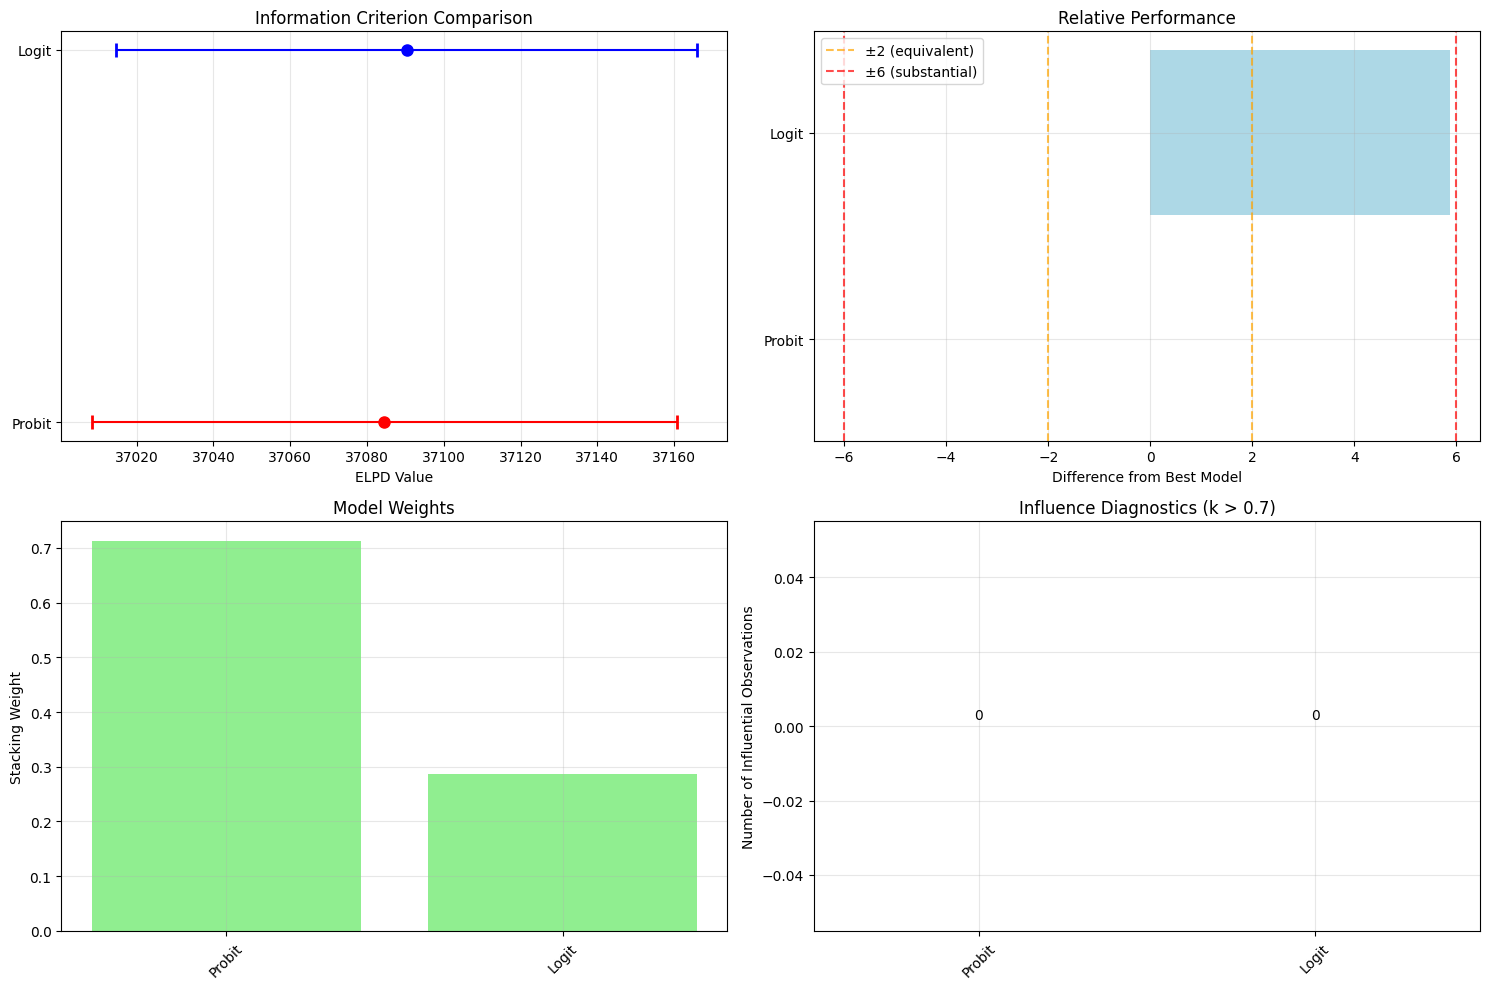


MCELREATH-STYLE MODEL COMPARISON SUMMARY
Best Model: Probit
Best Model IC Value: 37084.46

Model Interpretations:
  Probit: Best model - This model has the highest information criterion value
  Logit: Moderate difference - Difference of 5.87 is between 2 and 6

Recommendations:

Next Steps:
  → Perform posterior predictive checks on the selected model
  → Examine parameter estimates and their uncertainty
  → Consider sensitivity analysis for key parameters
  → If multiple models are close, use model averaging
 Rich plots created!


In [11]:
# Cell: Create Rich Model Comparison Plots
print(" Creating Rich Model Comparison Plots...")

# Import the plotting functions
from bayes_ordinal.workflow.cross_validation import (
    compare_models_interpretation, 
    plot_model_comparison_interpretation
)

# Get interpretation results
interpretation_results = compare_models_interpretation(
    models=models,
    idatas=idatas,
    ic="loo"
)

# Create the comprehensive plots
plot_model_comparison_interpretation(interpretation_results)

print(" Rich plots created!")

In [ ]:
# Cell: Display Comprehensive Results
print(" Displaying Comprehensive Results...")

# Import the display function
from bayes_ordinal.workflow.cross_validation import display_comparison_results

# Display all results in a readable format
display_comparison_results(advanced_results)

print(" Results displayed!")

 Displaying Comprehensive Results...

COMPREHENSIVE MODEL COMPARISON RESULTS

 BASIC COMPARISON:
        rank   elpd_loo  p_loo  elpd_diff  weight      se   dse  warning  \
Probit     0  37084.464  9.063       0.00   0.713  76.198  0.00    False   
Logit      1  37090.333  9.126       5.87   0.287  75.652  7.45    False   

           scale  n_bad_k  
Probit  deviance        0  
Logit   deviance        0  

 BEST MODEL: Probit

 STACKING WEIGHTS:
  Probit: 0.713
  Logit: 0.287

 BAYESIAN MODEL AVERAGING WEIGHTS:
  Logit: 0.500
  Probit: 0.500

 CONVERGENCE DIAGNOSTICS:
  Logit:  CONVERGED
    R-hat max: 1.003
    ESS min: 2759
  Probit:  CONVERGED
    R-hat max: 1.002
    ESS min: 2860

 INFLUENCE DIAGNOSTICS:
  Logit:
    Influential obs (k > 0.7): 0
    Max k: 0.021
    Mean k: -0.063
  Probit:
    Influential obs (k > 0.7): 0
    Max k: 0.032
    Mean k: -0.062

 MODEL COMPLEXITY:
  Logit: 2 parameters
  Probit: 2 parameters

 RECOMMENDATIONS:
  • Consider using stacking weights for